In [1]:
# Alif Firmansyah
# 1103204105
# Lecture 12 : Rock Paper Scissor
# Model : PyTorch AlexNet, Dataset : https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
# Dokumentasi / Referensi : https://www.kaggle.com/code/stpeteishii/rps-pytorch-lightning-alexnet

In [2]:
! pip install torch torchvision matplotlib

# 1. Import Library

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Subset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl

# 2. Inisialisasi Model

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
class_names = ['paper', 'rock', 'scissors']
N = list(range(len(class_names)))
normal_mapping = dict(zip(class_names, N)) 
reverse_mapping = dict(zip(N, class_names)) 

# 3. Import Dataset

In [13]:
path_label = []
for dirname, _, filenames in os.walk('/kaggle/input/rockpaperscissors'):
    for filename in filenames:
        if filename[-4:] == '.png':
            path = os.path.join(dirname, filename)
            label = dirname.split('/')[-1]
            path_label += [(path, normal_mapping[label])]

In [14]:
class ImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

# 4. Membuat Model PyTorch Lightning

In [15]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, path_label, transform=transform, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        labels = [label for _, label in self.path_label]
        train_indices, test_indices = train_test_split(list(range(len(labels))), test_size=0.2, stratify=labels)

        train_data = Subset(ImageDataset(self.path_label, self.transform), train_indices)
        test_data = Subset(ImageDataset(self.path_label, self.transform), test_indices)

        self.train_dataset = train_data
        self.test_dataset = test_data

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# 5. Membuat Model AlexNet

In [16]:
class AlexNet(pl.LightningModule):

    def __init__(self, num_classes=len(class_names)):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.model.classifier = nn.Sequential(   nn.Linear(9216,1024),
                                                 nn.ReLU(),
                                                 nn.Dropout(p=0.5),
                                                 nn.Linear(1024,len(class_names)), 
                                                 nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        return self.model(x)

    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# 6. Training Model

In [17]:
if __name__ == '__main__':    
    datamodule = DataModule(path_label)
    model = AlexNet()
    trainer = pl.Trainer(max_epochs=3)
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 159MB/s]  
2024-05-25 02:56:05.760352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has a

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.01376976165920496    │
└───────────────────────────┴───────────────────────────┘

# 7. Memuat Data Hasil Training

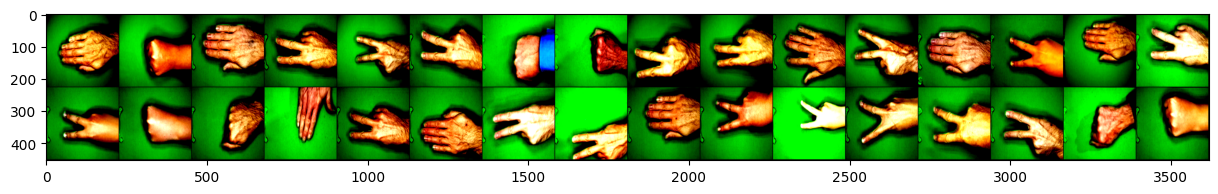

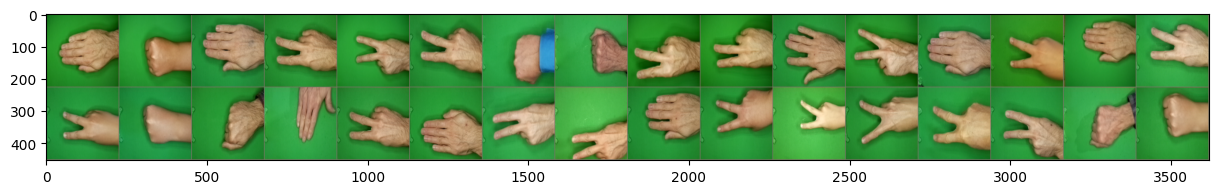

In [18]:
train_loader = datamodule.train_dataloader()

for images, labels in train_loader:
    break

im=make_grid(images,nrow=16)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# 8. Evaluasi Data

In [19]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

       paper     0.9930    1.0000    0.9965       285
        rock     1.0000    1.0000    1.0000       291
    scissors     1.0000    0.9933    0.9967       300

    accuracy                         0.9977       876
   macro avg     0.9977    0.9978    0.9977       876
weighted avg     0.9977    0.9977    0.9977       876



# 9. Save Model

In [20]:
trainer.save_checkpoint("alexnet_rockpaperscissors.ckpt")

In [21]:
model = AlexNet.load_from_checkpoint("alexnet_rockpaperscissors.ckpt")
model.eval()
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Linear(in_features=9216, out_features=1

# 10. Inisialisasi Testing

In [22]:
from PIL import Image
import torchvision.transforms as transforms

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

In [23]:
def classify_image(model, image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).item()
    return class_names[prediction]

# 11. Testing dengan Gambar Lokal

**11.1 Gunting**

In [27]:
new_image_path = "/kaggle/input/rockpaperscissors/scissors/277q9TUTAsBAbTCj.png"

model = AlexNet.load_from_checkpoint("alexnet_rockpaperscissors.ckpt")
model.eval()
model.to(device)

predicted_class = classify_image(model, new_image_path)
print(f"Gambar tersebut diklasifikasikan sebagai: {predicted_class}")

Gambar tersebut diklasifikasikan sebagai: scissors


**11.2 Batu**

In [26]:
new_image_path = "/kaggle/input/rockpaperscissors/rock/1COBZEE1ALiJIivQ.png"

model = AlexNet.load_from_checkpoint("alexnet_rockpaperscissors.ckpt")
model.eval()
model.to(device)

predicted_class = classify_image(model, new_image_path)
print(f"Gambar tersebut diklasifikasikan sebagai: {predicted_class}")

Gambar tersebut diklasifikasikan sebagai: rock
